In [52]:
# Notebook setup
# Note these libraries are used by Sage's notebook Profile_Examples_for_WHOI.ipynb
import requests
import os
import re
import xarray as xr
#!pip install netcdf4
import pandas as pd
import matplotlib.pyplot as plt
#!pip install cmocean
import cmocean as cmo

# libraries importate by Filipe in gist.ipynb
import ctd
import gsw
from ctd.read import _basename

# Make the Plots pretty
import seaborn as sns
sns.set()

# Supress open_mfdataset warnings
import warnings
warnings.filterwarnings('ignore')


# !!!!!! Note: I am running the notebooks on my local machine and thus do 
# not have to install netcdf4. Also I added cmocean to my environment. !!!!!!!!

# Load Data
Data has been requested by Stace already through the portal

October 2019 recovered

- Inshore water depth of 92 m
- Central inshore water depth of 126 m
- Central offshore water depth of 146 m
- Offshore water depth of 451 m
- Distance between inshore and central inshore 15.32 km, between central inshore and central offshore 14.47 km, between central offshore and offshore 17.91 km (link to cruise report)


In [2]:
# Provide URL to load a single file that has already been downloaded to OOI's OPENDAP server
# remember to use #fillmismatch
# Create directory that includes all urls
data_url = {}
data_url['inshore'] = 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sbeaulieu@whoi.edu/20200806T132326640Z-CP03ISPM-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered/deployment0003_CP03ISPM-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered_20191006T150003-20191031T212239.977728.nc#fillmismatch'
data_url['central_inshore'] = 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sbeaulieu@whoi.edu/20200806T132900316Z-CP02PMCI-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered/deployment0013_CP02PMCI-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered_20191007T210003-20191031T212442.986087.nc#fillmismatch'
data_url['central_offshore'] = 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sbeaulieu@whoi.edu/20200806T133142674Z-CP02PMCO-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered/deployment0013_CP02PMCO-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered_20191008T140003-20191031T212529.983845.nc#fillmismatch'
data_url['offshore'] = 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sbeaulieu@whoi.edu/20200806T133343088Z-CP04OSPM-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered/deployment0012_CP04OSPM-WFP01-03-CTDPFK000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered_20191013T160003-20191031T211622.990750.nc#fillmismatch'


In [30]:
# Load the data file using xarray
def load2xarray(location):
    """
    Load data at given location and reduce to variables of interest.
    """
    ds = xr.open_dataset(data_url[location])
    ds = ds.swap_dims({'obs': 'time'}) #Swap dimensions
    print('Dataset '+ location +' has %d points' % ds.time.size)
    ds = ds[['ctdpf_ckl_seawater_pressure','ctdpf_ckl_seawater_temperature','practical_salinity']]
    return ds

ds={}
for loc in list(data_url.keys()):
    ds[loc] = load2xarray(loc)

Dataset inshore has 158237 points
Dataset central_inshore has 210513 points
Dataset central_offshore has 236989 points
Dataset offshore has 199587 points


# Plot scatter time series

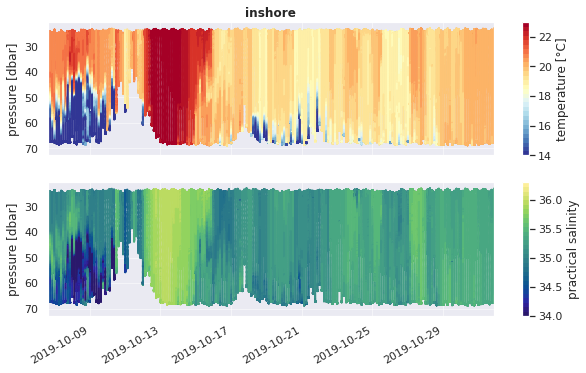

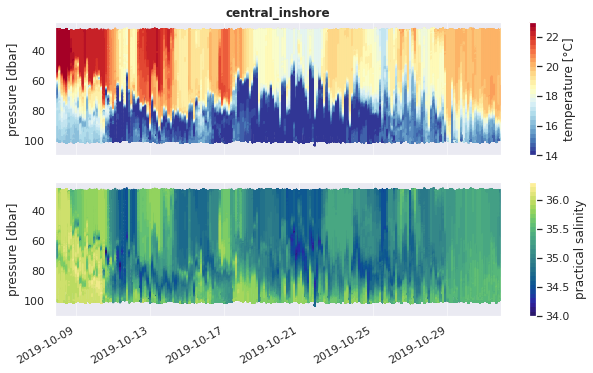

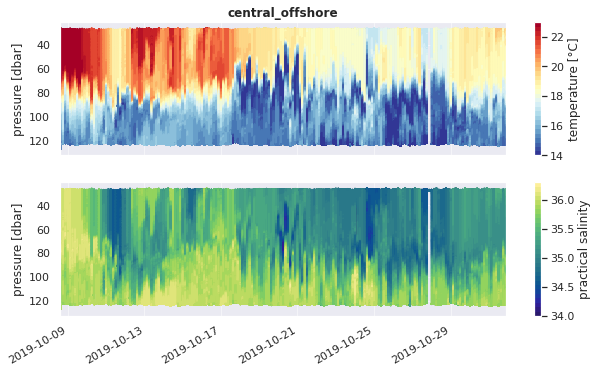

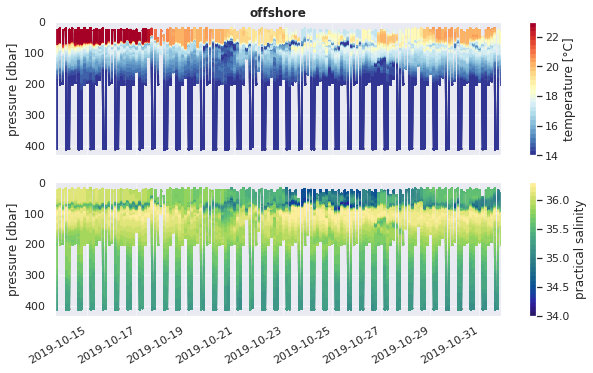

In [51]:
#####################################
# plotting function

def scatter_timeseries(ds,location=None):
    plt.rcParams.update({'font.size': 14})
    fig,ax = plt.subplots(figsize=(10,6),nrows=2,sharex=True,constrained_layout=False)
    cc = ax[0].scatter(ds.time,ds.ctdpf_ckl_seawater_pressure,s=1,
                    c=ds.ctdpf_ckl_seawater_temperature,
                    cmap = plt.get_cmap('RdYlBu_r',30),vmin=14,vmax=23)
    plt.colorbar(cc,ax=ax[0],label='temperature [\N{DEGREE SIGN}C]')
#     plt.xticks(rotation=30)
    ax[0].set_xlim(ds.time[0],ds.time[-1]) # Set the time limits to match the dataset


    cc = ax[1].scatter(ds.time,ds.ctdpf_ckl_seawater_pressure,s=1,
                    c=ds.practical_salinity,
                    cmap = plt.get_cmap('cmo.haline',30),vmin=34,vmax=36.3)
    plt.colorbar(cc,ax=ax[1],label='practical salinity')
#     plt.xticks(rotation=30)

    for axh in ax.flat: axh.set_ylabel('pressure [dbar]'); axh.invert_yaxis();
    if location: ax[0].set_title(location,fontweight='bold')
    fig.autofmt_xdate()

    return fig,ax

#######################################
# plot scatter timeseries for all locations
for loc in list(data_url.keys()):
    scatter_timeseries(ds[loc],loc)

# Extract downcast

In order to be able to plot a section we need individual profiles at each location at a given time. We cannot just resample by time because it is profiling data, which is not binned in vertical.  
A few steps I would take next:   
- extract the downcast only
- assign one time to each profile

**Trying to split casts based on changes in pressure**

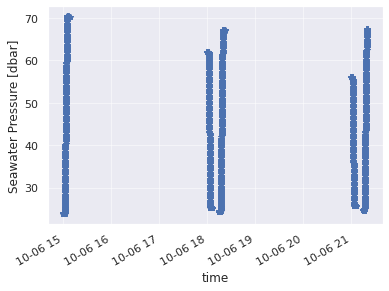

In [222]:
# plot first few profiles from initial dataset

dummy = ds['inshore']
dummy.ctdpf_ckl_seawater_pressure[0:2000].plot(marker='*',linestyle='')

We can see that there is always a downcast, followed by a time gap, then upcast and next downcast.

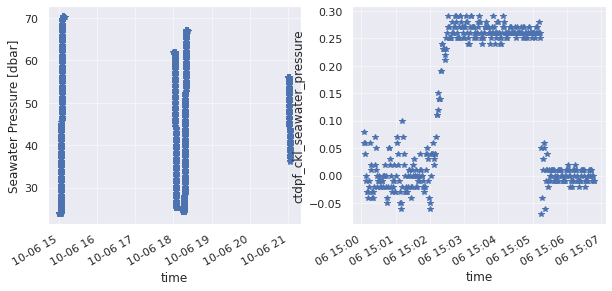

In [225]:
# plot first cast to check
fig,ax = plt.subplots(ncols=2,figsize=(10,4))
dummy.ctdpf_ckl_seawater_pressure[0:1500].plot(marker='*',linestyle='',ax=ax[0])

# plot difference in pressure
dummy.ctdpf_ckl_seawater_pressure[0:400].diff(dim='time').plot(marker='*',linestyle='',ax=ax[1])

Based on these plots I can apply a thresshold of 0.1 for diff(pressure). Tried 0.2 but then lose too much data.

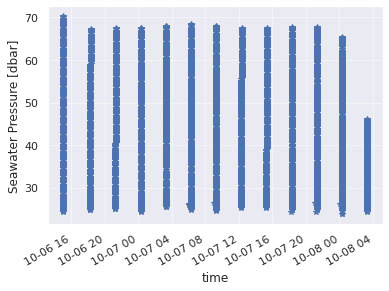

In [218]:
# select only data where pressure is increasing
dummy_down = dummy.where(dummy.ctdpf_ckl_seawater_pressure.diff(dim='time')>0.1)

# plot to check if it worked
dummy_down.ctdpf_ckl_seawater_pressure[0:10000].plot(marker='*',linestyle='')

Seems to work sort of ok?

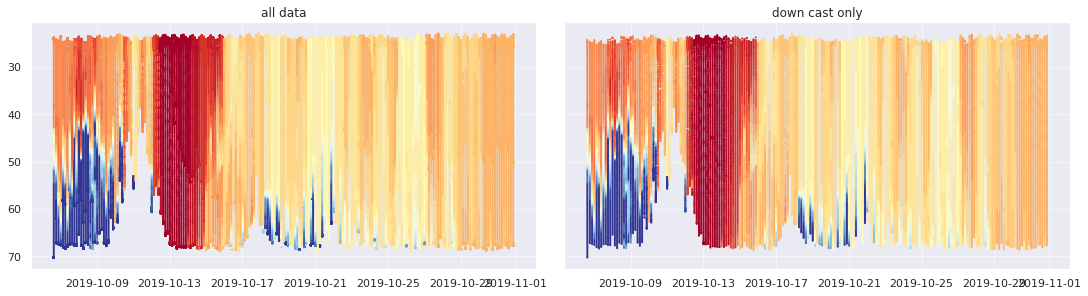

In [217]:
# plt scatter of old vs. new
fig,ax = plt.subplots(ncols=2,figsize=(15,4),sharey=True,constrained_layout=True)
ax[0].scatter(dummy.time,dummy.ctdpf_ckl_seawater_pressure,s=1,
                    c=dummy.ctdpf_ckl_seawater_temperature,
                    cmap = plt.get_cmap('RdYlBu_r',30),vmin=14,vmax=23)
ax[0].set_title('all data')
# ax[0].invert_yaxis()

ax[1].scatter(dummy_down.time,dummy_down.ctdpf_ckl_seawater_pressure,s=1,
                    c=dummy_down.ctdpf_ckl_seawater_temperature,
                    cmap = plt.get_cmap('RdYlBu_r',30),vmin=14,vmax=23)
ax[1].set_title('down cast only')
ax[1].invert_yaxis()


**Next step: Assign only one time for each profile?**